In [1]:
!pip install ray
!pip install tensorboardX
!pip install hyperopt
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 35.6 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter

from ray.tune.search.optuna import OptunaSearch


from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from ray import tune
import ray

np.random.seed(0)
tf.random.set_seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_csv(
    '/content/drive/MyDrive/datasets/crypto/btc/ready/ta_corr_01_fd.csv',
    parse_dates=True
    )
target_col = 'log_returns'
exclude_cols = ['Close', 'log_close']
df = df.set_index(['timestamp'])
df.index = pd.to_datetime(df.index)
df

,log_close,Close,log_returns,diff_fear_greed,volatility_kcp,volume_em,volume_vpt,momentum_stoch_rsi,volatility_bbp,momentum_stoch,...,trend_macd_diff,trend_stc,volume_sma_em,trend_aroon_ind,momentum_tsi,trend_aroon_down,trend_vortex_ind_neg,trend_psar_down_indicator,trend_adx_neg,volatility_bbli
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-11-27,5.912611,369.670013,0.003523,-0.006765,0.501327,-40.468161,-3.149466e+05,0.388997,0.425509,34.013853,...,-0.855557,24.373770,-502.853674,36.0,-0.527280,4.0,1.288202,0.0,20.285280,0.0
2014-11-28,5.930777,376.446991,0.018166,0.007878,0.726950,-52.121651,4.515396e+05,0.748693,0.490535,48.927911,...,-0.354460,46.507056,-281.225092,32.0,0.152113,4.0,1.133492,0.0,22.078843,0.0
2014-11-29,5.928234,375.490997,-0.002543,-0.012831,0.700354,927.476194,3.816202e+05,0.714180,0.469128,47.481343,...,-0.099079,68.204734,0.631289,28.0,0.610003,4.0,1.070125,0.0,20.806231,0.0
2014-11-30,5.935019,378.046997,0.006784,-0.003504,0.764513,-196.001510,2.354075e+04,0.813134,0.496233,51.348971,...,0.213258,84.102367,40.733570,20.0,1.277897,8.0,1.032653,0.0,20.063468,0.0
2014-12-01,5.938182,379.244995,0.003164,-0.007124,0.718714,133.611388,9.986327e+04,1.000000,0.504775,69.447910,...,0.457770,92.051184,-12.443357,20.0,1.977937,4.0,1.119928,0.0,19.494893,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29,10.230843,27745.884766,-0.012171,0.987829,1.050246,2858.497078,4.753301e+08,0.811280,0.932253,73.001414,...,142.801589,75.000019,451.343496,-76.0,-8.043034,80.0,0.918640,0.0,18.152938,0.0
2023-05-30,10.229273,27702.349609,-0.001570,-0.001570,0.955887,-624.340933,-2.044453e+08,0.787049,0.897492,71.288406,...,158.821013,87.500010,434.361789,-72.0,-5.906286,76.0,0.923086,0.0,17.383497,0.0
2023-05-31,10.211695,27219.658203,-0.017578,-1.017578,0.580642,-2882.568661,-2.935917e+08,0.526399,0.601630,52.295615,...,132.467667,93.750005,251.374776,-68.0,-5.567434,72.0,0.962587,0.0,22.440350,0.0


In [6]:
from models.transformer.my_functrions import make_dataset

num_of_test = 42
horizon=14
#horizon=1
timestep=10

Xtrain, Ytrain, Xtest, Ytest, XVal, YVal, scaler = make_dataset(
   df, target_col='log_returns', exclude_cols=exclude_cols, timestep=timestep, ntest=num_of_test, horizon=horizon
)


num_features = Xtrain.shape[-1]

X.shape (3100, 10, 36) Y.shape (3100, 1)


In [8]:


config_test = {
    'input_dense_layers': 4,
    'units_input_dense_layers': 64,
    'lstm_layers': 4,
    'units_lstm_layers': 64,
    'output_dense_layers': 4,
    'units_output_dense_layers': 256,
    'dropout': 0.2,

    # 'dense1_units': 32,
    # 'dense2_units': 32,
    # 'dense3_units': 32,

    # 'lstm1_units': 64,
    # 'lstm2_units': 128,
    # 'lstm3_units': 32,

    'n_epochs': 100,
    "lr": 0.00001,
	"batch_size": 8, 
    'patience':40,
}

In [9]:


def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))


def build_lstm_model(config):
    input = Input(shape=(timestep, num_features))
    
    x = input

    x = Dense(config['units_input_dense_layers'])(x)
    x = Dropout(rate=config['dropout'])(x)
    
    for i in range(config['lstm_layers']):
        x = LSTM(config['units_lstm_layers'], return_sequences=True)(x)
        x = Dropout(rate=config['dropout'])(x)

    x = GlobalMaxPooling1D()(x)

    for i in range(config['output_dense_layers']):
        x = Dense(config['units_output_dense_layers'])(x)

    x = Flatten(data_format='channels_first')(x)
    x = Dense(horizon)(x)
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

In [10]:

model = build_lstm_model(config_test)
model.compile(
  loss='mse',
  optimizer='adam',
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 36)]          0         
                                                                 
 dense (Dense)               (None, 10, 64)            2368      
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0     

In [ ]:
history = model.fit(
  Xtrain,
  Ytrain,
  batch_size=16,
  epochs=100,
  validation_data=(XVal, YVal)
)

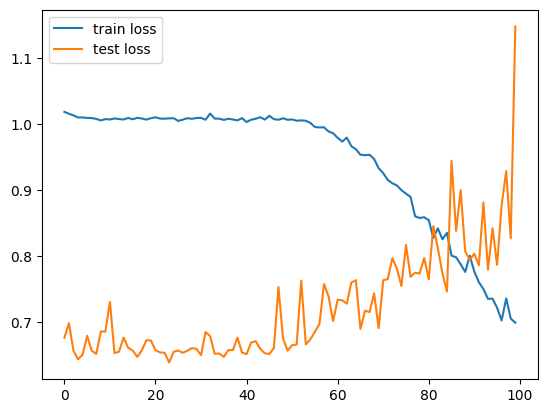

In [12]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
class TuneReporter(tf.keras.callbacks.Callback):
    """Tune Callback for Keras."""

    def __init__(self, reporter=None, freq="epoch", logs=None):
        """Initializer.
        Args:
            freq (str): Sets the frequency of reporting intermediate results.
        """
        self.iteration = 0
        logs = logs or {}
        self.freq = freq
        super(TuneReporter, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        from ray import tune
        logs = logs or {}
        if not self.freq == "epoch":
            return
        self.iteration += 1
        tune.report(keras_info=logs, val_loss=logs['val_loss'], )

In [ ]:
config = {
    'input_dense_layers': tune.choice([2, 1]),
    'units_input_dense_layers': tune.choice([128, 256, 512]),
    'lstm_layers': tune.choice([2, 4, 8]),
    'units_lstm_layers': tune.choice([128, 256, 512]),
    'output_dense_layers': tune.choice([0, 2, 4]),
    'units_output_dense_layers': tune.choice([128, 256, 512]),
    'dropout': 0.1,

    # 'dense1_units': 32,
    # 'dense2_units': 32,
    # 'dense3_units': 32,

    # 'lstm1_units': 64,
    # 'lstm2_units': 128,
    # 'lstm3_units': 32,

    'n_epochs': 100,
    'patience':40,
    "lr": tune.choice([0.0001, 0.00001]),
	"batch_size": tune.choice([16, 32,]), 
}

In [ ]:
from ray.tune.integration.keras import TuneReportCallback

class Trainable:
    def __init__(self, Xtrain, Ytrain, Xtest, Ytest, XVal, YVal ):
        self.Xtrain, self.Ytrain, self.XVal, self.YVal = Xtrain, Ytrain, XVal, YVal


    def train(self, config, reporter=None):
        model = build_lstm_model(config)

        filename = f"lstm_inputs={config['input_dense_layers']},{config['units_input_dense_layers']}__lstms={config['lstm_layers']},{config['units_lstm_layers']}__outputs={config['output_dense_layers']},{config['units_output_dense_layers']}.h5"
        check_point = ModelCheckpoint(f'/content/drive/MyDrive/models/lstm/checkpoints/{filename}', monitor='val_loss', save_best_only=True)
        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=config['patience'],
            mode="min",
        )
        tune_report = TuneReportCallback({"val_loss": "val_loss", 'train_loss':'loss'})
        model.compile(
            optimizer='adam',
            loss='mse'
        )
        history = model.fit(
            self.Xtrain,
            self.Ytrain,
            epochs=config['n_epochs'],
            batch_size=config['batch_size'],
            callbacks=[tune_report, check_point, early_stop ],
            validation_data=(self.XVal, self.YVal),
            
        )

In [ ]:
import logging
logger = logging.getLogger('my_logger')

In [ ]:
trainer = Trainable(Xtrain, Ytrain, Xtest, Ytest, XVal, YVal)

trainer.train(config_test)

In [ ]:
trainer = Trainable(Xtrain, Ytrain, Xtest, Ytest, XVal, YVal)

trainable = tune.with_resources(
    trainer.train,
    {
        "cpu": 2,
        "gpu": 1,
        #'accelerator': NVIDIA_TESLA_A100
    }
)
num_samples = 1

algo = OptunaSearch(
    metric="val_loss",
    mode="min",
)
algo = ConcurrencyLimiter(algo, max_concurrent=2)
scheduler = AsyncHyperBandScheduler()


#logger.info("Starting hyperparameter tuning")
analysis = tune.run(
    trainable, 
    metric="val_loss",
    mode="min",
    config=config_test,

    num_samples=num_samples,
    #search_alg=algo,
    #scheduler=scheduler,

    raise_on_failed_trial=True,
    #resources_per_trial={"cpu": 16, "gpu": 2}
    local_dir=f"/content/drive/MyDrive/models/lstm/checkpoints/tune_lstm3"
)

ERROR:ray.tune.tune:Trials did not complete: [_trainable_7980b_00000]
Continue running this experiment with: tune.run(..., resume=True)


In [ ]:
best_config = analysis.get_best_config(metric="val_loss", mode='min')

In [ ]:
best_config


{'input_dense_layers': 1,
 'units_input_dense_layers': 128,
 'lstm_layers': 8,
 'units_lstm_layers': 512,
 'output_dense_layers': 4,
 'units_output_dense_layers': 256,
 'dropout': 0.1,
 'n_epochs': 100,
 'patience': 40,
 'lr': 0.0001,
 'batch_size': 32}

In [ ]:
best_config

{'input_dense_layers': 4,
 'units_input_dense_layers': 64,
 'lstm_layers': 4,
 'units_lstm_layers': 64,
 'output_dense_layers': 4,
 'units_output_dense_layers': 256,
 'dropout': 0.1,
 'n_epochs': 100,
 'patience': 40,
 'lr': 1e-05,
 'batch_size': 8}

In [ ]:

i = Input(shape=(timestep, num_features))
x = Dense(32)(i)
x = Flatten(data_format='channels_first')(x)
x = Dense(horizon)(x)
#x = Flatten()(x)

model = Model(i, x)

In [ ]:



model.compile(
  loss='mse',
  optimizer='adam',
)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10, 36)]          0         
                                                                 
 dense_19 (Dense)            (None, 10, 32)            1184      
                                                                 
 flatten_4 (Flatten)         (None, 320)               0         
                                                                 
 dense_20 (Dense)            (None, 21)                6741      
                                                                 
Total params: 7,925
Trainable params: 7,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  batch_size=16,
  epochs=100,
  validation_data=(XVal, YVal)
)

In [ ]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

2/2 [==============================] - 0s 5ms/step


In [ ]:
from models.transformer.my_functrions import test_predictions_multistep

train = df.iloc[:-num_of_test]
last_train = df.iloc[-1]['log_close']

test_predictions_multistep(Ptest, Ytest, scaler,  unscale=False, last_train=last_train, apply_func_to_preds=None)